<a href="https://colab.research.google.com/github/vineet891/FODS-Assignment/blob/PartA/Assignment1/FODS_A1_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Regression

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

import tqdm
from tqdm import notebook

**Loading Dataset**

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/My Drive/FODSAssignment/FoDS-A1.csv')
df

,Strength,Temperature,Pressure
0,30.7,240,16
1,24.7,250,18
2,30.6,260,16
3,32.8,240,10
4,20.7,240,20
...,...,...,...
1645,32.5,270,20
1646,38.6,290,14
1647,39.7,290,12
1648,14.6,200,20


Data Preprocessing

In [4]:
#shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df

,Strength,Temperature,Pressure
0,43.8,290,12
1,31.2,270,16
2,34.7,300,18
3,31.7,280,18
4,40.2,290,12
...,...,...,...
1645,20.7,210,20
1646,25.2,260,20
1647,22.4,200,10
1648,22.7,220,14


In [5]:
df.describe()

,Strength,Temperature,Pressure
count,1650.000000,1650.000000,1650.000000
mean,30.000000,250.000000,15.000000
std,7.390248,31.632364,3.416686
min,12.400000,200.000000,10.000000
25%,24.400000,220.000000,12.000000
50%,30.200000,250.000000,15.000000
75%,35.700000,280.000000,18.000000
max,48.700000,300.000000,20.000000


In [6]:
# standardize the dataset
df = (df-np.mean(df,axis=0))/np.std(df,axis=0)
df

,Strength,Temperature,Pressure
0,1.867892,1.264911,-0.87831
1,0.162425,0.632456,0.29277
2,0.636166,1.581139,0.87831
3,0.230103,0.948683,0.87831
4,1.380616,1.264911,-0.87831
...,...,...,...
1645,-1.258797,-1.264911,1.46385
1646,-0.649701,0.316228,1.46385
1647,-1.028694,-1.581139,-1.46385
1648,-0.988088,-0.948683,-0.29277


In [7]:
# split the data set into 70:30 train:test 
split_index = int(0.7*len(df))

data = df.values
X = data[:,:-1]
y = data[:,-1]

train_X = X[:split_index]
train_y = y[:split_index]

test_X = X[split_index:]
test_y = y[split_index:]


array([[ 1.86789178,  1.26491106],
       [ 0.16242537,  0.63245553],
       [ 0.63616604,  1.58113883],
       ...,
       [ 1.05576492,  1.26491106],
       [ 0.09474813,  0.9486833 ],
       [ 0.23010261, -0.31622777]])

In [8]:
#transform the data to degree n
def transform(X,degree):
  X_trans = np.ones((len(X[:,1]), 1), dtype=int)
  for i in range(degree+1):
    for j in range(degree+1-i):
      if i!=0 or j!=0:
        t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
        X_trans = np.concatenate((X_trans, t.T), axis=1)
  return X_trans

**MODEL**

In [27]:
class Regression():

    def __init__(self, X_train, X_test, y_train, y_test):
        self.w = None
        self.X_train, self.X_test, self.y_train, self.y_test = X_train,X_test,y_train, y_test

    def polynomial(self, X):    
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])  

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        return (y_pred - y)*x

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)[0]
        print("Testing Error is ", test_loss)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=True, printValues=True):

        self.w = np.random.randn(1, X.shape[1])     

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        count=0
        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)   
                    self.w -= learning_rate * (dw/X.shape[0])   

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)   
                self.w -= learning_rate * dw   

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]  
                if printValues and i%50==0:
                    print('Epoch:', i,'Loss:', loss[i])

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

        self.evaluate(self.X_test,self.y_test)


**0 Degree Polynomial**

In [49]:
# transform the dataset to degree 0
x_train_trans_0 = transform(train_X,0)
x_test_trans_0 = transform(test_X,0)

Training...


  0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.5021189146339171
Epoch: 50 Loss: 0.9950930052152606
Epoch: 100 Loss: 0.9784077888972602
Epoch: 150 Loss: 0.9779557310007672


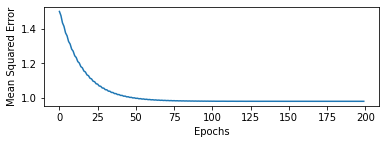

Testing
Testing Error is  1.0519845204836467


In [50]:
# Train and Test the 0-degree regression model with Gradient Descent
GD0 = Regression(x_train_trans_0, x_test_trans_0, train_y, test_y)
GD0.fit(x_train_trans_0, train_y,epochs = 200, learning='GD', learning_rate=0.01)

In [101]:
"""file = open('/content/gdrive/My Drive/FODSAssignment/GD0.pickle', 'wb')
pickle.dump(GD0, file)
file.close()"""

In [102]:
"""file = open('/content/gdrive/My Drive/FODSAssignment/GD0.pickle', 'rb')      #use this code
temp = pickle.load(file)
file.close()"""

In [103]:
# temp.evaluate(x_test_trans_0, test_y)

Testing Error is  1.0519845204836467


Training...


  0%|          | 0/1000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 4.3776116370775116
Epoch: 50 Loss: 2.2709813989361365
Epoch: 100 Loss: 1.3502645308879544
Epoch: 150 Loss: 1.1507002769827306
Epoch: 200 Loss: 1.0093672405079206
Epoch: 250 Loss: 0.984348016744303
Epoch: 300 Loss: 0.982216274459865
Epoch: 350 Loss: 0.983682471224987
Epoch: 400 Loss: 0.9779636885695441
Epoch: 450 Loss: 0.9807910392721535
Epoch: 500 Loss: 0.9794939231812685
Epoch: 550 Loss: 0.9841378277619376
Epoch: 600 Loss: 0.9864295900169082
Epoch: 650 Loss: 0.9859501663069614
Epoch: 700 Loss: 0.9800908305090767
Epoch: 750 Loss: 0.9840838579484353
Epoch: 800 Loss: 0.9903941225613353
Epoch: 850 Loss: 0.9833668456826588
Epoch: 900 Loss: 0.984905335899361
Epoch: 950 Loss: 0.983057276995097


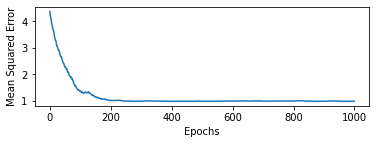

Testing
Testing Error is  1.053706772612511


In [51]:
# Train and Test the 0-degree regression model with Stochastic Gradient Descent
SGD0 = Regression(x_train_trans_0, x_test_trans_0, train_y, test_y)
SGD0.fit(x_train_trans_0, train_y,epochs = 1000, learning='SGD', learning_rate=0.01)

In [104]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD0.pickle', 'wb')
# pickle.dump(SGD0, file)
# file.close()

**1 Degree Polynomial**

In [37]:
x_train_trans_1 = transform(train_X,1)
x_test_trans_1 = transform(test_X,1)

Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.252748137330445
Epoch: 50 Loss: 0.24270729448673964
Epoch: 100 Loss: 0.20014098936504052
Epoch: 150 Loss: 0.19851822626093277
Epoch: 200 Loss: 0.19852739017922655
Epoch: 250 Loss: 0.1985465734225003
Epoch: 300 Loss: 0.19855156541217886
Epoch: 350 Loss: 0.19855269103288486
Epoch: 400 Loss: 0.19855293796350737
Epoch: 450 Loss: 0.19855299181835812


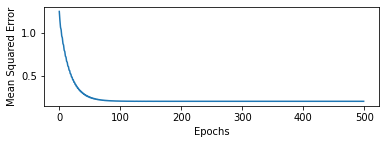

Testing
Testing Error is  0.20851111611268489


In [39]:
GD1 = Regression(x_train_trans_1, x_test_trans_1, train_y, test_y)
GD1.fit(x_train_trans_1, train_y,epochs = 500, learning='GD', learning_rate=0.01)

In [105]:
# file = open('/content/gdrive/My Drive/FODSAssignment/GD1.pickle', 'wb')
# pickle.dump(GD1, file)
# file.close()

Training...


  0%|          | 0/1500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 6.68044685254399
Epoch: 50 Loss: 3.1928243718200093
Epoch: 100 Loss: 1.906651452273841
Epoch: 150 Loss: 1.3250209795786323
Epoch: 200 Loss: 1.067310434645728
Epoch: 250 Loss: 0.9671162847866018
Epoch: 300 Loss: 0.8719829291550042
Epoch: 350 Loss: 0.7337824828139363
Epoch: 400 Loss: 0.629897745022932
Epoch: 450 Loss: 0.57036209656886
Epoch: 500 Loss: 0.5256355414905443
Epoch: 550 Loss: 0.47631793778154474
Epoch: 600 Loss: 0.4379089358698669
Epoch: 650 Loss: 0.42056835670835924
Epoch: 700 Loss: 0.37027991427594587
Epoch: 750 Loss: 0.3564577720263416
Epoch: 800 Loss: 0.333194272460368
Epoch: 850 Loss: 0.32509318246073454
Epoch: 900 Loss: 0.29751696110350534
Epoch: 950 Loss: 0.28302196168677407
Epoch: 1000 Loss: 0.26965718437793135
Epoch: 1050 Loss: 0.25943371065420945
Epoch: 1100 Loss: 0.25097707445606354
Epoch: 1150 Loss: 0.24448759284372784
Epoch: 1200 Loss: 0.24063595346816954
Epoch: 1250 Loss: 0.23617648542753078
Epoch: 1300 Loss: 0.22823692432163872
Epoch: 1350 Loss: 0

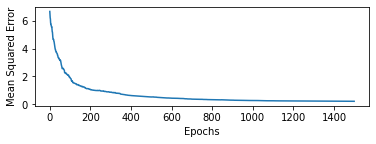

Testing
Testing Error is  0.23038992092019328


In [47]:
SGD1 = Regression(x_train_trans_1, x_test_trans_1, train_y, test_y)
SGD1.fit(x_train_trans_1, train_y,epochs = 1500, learning='SGD', learning_rate=0.01)

In [106]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD1.pickle', 'wb')
# pickle.dump(SGD1, file)
# file.close()

**2 Degree Polynomial**

In [31]:
x_train_trans_2 = transform(train_X,2)
x_test_trans_2 = transform(test_X,2)

Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 11.444081659990067
Epoch: 50 Loss: 0.20478488774322232
Epoch: 100 Loss: 0.19818331039584428
Epoch: 150 Loss: 0.19598545914472992
Epoch: 200 Loss: 0.19525258794522993
Epoch: 250 Loss: 0.19503498255031654
Epoch: 300 Loss: 0.19498890532316382
Epoch: 350 Loss: 0.19499358317259682
Epoch: 400 Loss: 0.19500887152451302
Epoch: 450 Loss: 0.1950229333702624


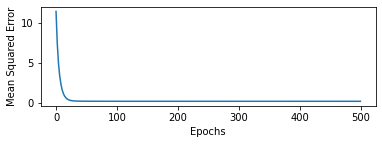

Testing
Testing Error is  0.20628454184055797


In [68]:
GD2 = Regression(x_train_trans_2, x_test_trans_2, train_y, test_y)
GD2.fit(x_train_trans_2, train_y,epochs = 500, learning='GD', learning_rate=0.001)

In [107]:
# file = open('/content/gdrive/My Drive/FODSAssignment/GD2.pickle', 'wb')
# pickle.dump(GD2, file)
# file.close()

Training...


  0%|          | 0/1500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 8.303424510412103
Epoch: 50 Loss: 0.6815724996482869
Epoch: 100 Loss: 0.6082629472305087
Epoch: 150 Loss: 0.5489232192254534
Epoch: 200 Loss: 0.48875848670051397
Epoch: 250 Loss: 0.48650843138294264
Epoch: 300 Loss: 0.413218138547025
Epoch: 350 Loss: 0.3862917491777189
Epoch: 400 Loss: 0.3536133020742487
Epoch: 450 Loss: 0.32439076630551644
Epoch: 500 Loss: 0.31700648593924985
Epoch: 550 Loss: 0.3081810652647152
Epoch: 600 Loss: 0.2760652451553324
Epoch: 650 Loss: 0.298497574326398
Epoch: 700 Loss: 0.27140700767429937
Epoch: 750 Loss: 0.27796453554334893
Epoch: 800 Loss: 0.23809921809180945
Epoch: 850 Loss: 0.23296243092199306
Epoch: 900 Loss: 0.2419760309117905
Epoch: 950 Loss: 0.2260062335408222
Epoch: 1000 Loss: 0.23649410404083418
Epoch: 1050 Loss: 0.2303013570203943
Epoch: 1100 Loss: 0.2275252041379468
Epoch: 1150 Loss: 0.21882228098391834
Epoch: 1200 Loss: 0.20893788144252196
Epoch: 1250 Loss: 0.22792188645373787
Epoch: 1300 Loss: 0.2137306098542141
Epoch: 1350 Los

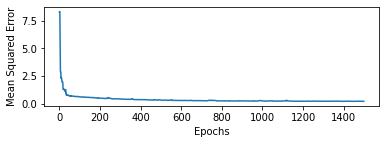

Testing
Testing Error is  0.22000291226802682


In [44]:
SGD2 = Regression(x_train_trans_2, x_test_trans_2, train_y, test_y)
SGD2.fit(x_train_trans_2, train_y,epochs = 1500, learning='SGD', learning_rate=0.01)

In [108]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD2.pickle', 'wb')
# pickle.dump(SGD2, file)
# file.close()

**3 Degree Polynomial**

In [60]:
x_train_trans_3 = transform(train_X,3)
x_test_trans_3 = transform(test_X,3)


Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.5744551029760947
Epoch: 50 Loss: 0.23987406904963837
Epoch: 100 Loss: 0.20346105838812129
Epoch: 150 Loss: 0.19186619926558277
Epoch: 200 Loss: 0.1878145931754138
Epoch: 250 Loss: 0.1863827296574105
Epoch: 300 Loss: 0.18586071997021714
Epoch: 350 Loss: 0.18564523754628962
Epoch: 400 Loss: 0.18552787914819982
Epoch: 450 Loss: 0.18544012196574017


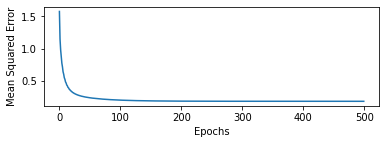

Testing
Testing Error is  0.19576571356460148


In [65]:
GD3 = Regression(x_train_trans_3, x_test_trans_3, train_y, test_y)
GD3.fit(x_train_trans_3, train_y,epochs = 500, learning='GD', learning_rate=0.001)

In [109]:
# file = open('/content/gdrive/My Drive/FODSAssignment/GD3.pickle', 'wb')
# pickle.dump(GD3, file)
# file.close()

Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 7.123438137979889
Epoch: 50 Loss: 0.7064694604594428
Epoch: 100 Loss: 0.48465373399024475
Epoch: 150 Loss: 0.4331473479354547
Epoch: 200 Loss: 0.4684451625529419
Epoch: 250 Loss: 0.45268051735654863
Epoch: 300 Loss: 0.548253942206508
Epoch: 350 Loss: 0.3730467303554703
Epoch: 400 Loss: 0.3876718363401456
Epoch: 450 Loss: 0.2854073369124503
Epoch: 500 Loss: 0.3197968880267297
Epoch: 550 Loss: 0.39122914871212433
Epoch: 600 Loss: 6.122585127063473
Epoch: 650 Loss: 0.2819438744831445
Epoch: 700 Loss: 0.2577809020335824
Epoch: 750 Loss: 0.3020686076511504
Epoch: 800 Loss: 0.2612474621451373
Epoch: 850 Loss: 0.2921598489665734
Epoch: 900 Loss: 0.29159047254221837
Epoch: 950 Loss: 0.3295502097607922
Epoch: 1000 Loss: 0.23448897766887833
Epoch: 1050 Loss: 0.29261194162551696
Epoch: 1100 Loss: 0.30874835572542403
Epoch: 1150 Loss: 0.6921802595944462
Epoch: 1200 Loss: 0.2443405201857931
Epoch: 1250 Loss: 0.23401250199326415
Epoch: 1300 Loss: 0.27107855479260823
Epoch: 1350 Loss: 

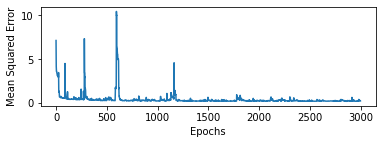

Testing
Testing Error is  0.263491283034752


In [79]:
SGD3 = Regression(x_train_trans_3, x_test_trans_3, train_y, test_y)
SGD3.fit(x_train_trans_3, train_y,epochs = 3000, learning='SGD', learning_rate=0.01)

In [110]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD3.pickle', 'wb')
# pickle.dump(SGD3, file)
# file.close()

**4 Degree Polynomial**

In [71]:
x_train_trans_4 = transform(train_X,4)
x_test_trans_4 = transform(test_X,4)


Training...


  0%|          | 0/700 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 22.562478994010842
Epoch: 50 Loss: 0.8191809188136185
Epoch: 100 Loss: 0.46820421649931654
Epoch: 150 Loss: 0.37240271040875017
Epoch: 200 Loss: 0.3228102445357056
Epoch: 250 Loss: 0.2915977458574706
Epoch: 300 Loss: 0.27055315309403677
Epoch: 350 Loss: 0.2558149650727552
Epoch: 400 Loss: 0.24522388043276386
Epoch: 450 Loss: 0.23746408447986622
Epoch: 500 Loss: 0.23168797156850554
Epoch: 550 Loss: 0.2273281391790216
Epoch: 600 Loss: 0.22399420921598864
Epoch: 650 Loss: 0.22141210678798934


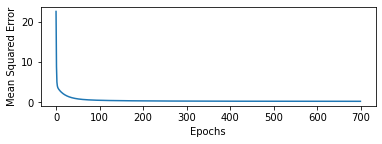

Testing
Testing Error is  0.2291862745944117


In [80]:
GD4 = Regression(x_train_trans_4, x_test_trans_4, train_y, test_y)
GD4.fit(x_train_trans_4, train_y,epochs = 700, learning='GD', learning_rate=0.00005)

In [112]:
# file = open('/content/gdrive/My Drive/FODSAssignment/GD4.pickle', 'wb')
# pickle.dump(GD4, file)
# file.close()

Training...


  0%|          | 0/5000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 46.478667764752004
Epoch: 50 Loss: 20.70551291465929
Epoch: 100 Loss: 9.778862783512919
Epoch: 150 Loss: 5.940713205751675
Epoch: 200 Loss: 2.899191619355129
Epoch: 250 Loss: 3.030084563079767
Epoch: 300 Loss: 2.037394117585261
Epoch: 350 Loss: 1.9886282622482103
Epoch: 400 Loss: 1.5870671122147149
Epoch: 450 Loss: 2.018019180627736
Epoch: 500 Loss: 2.0560204731206047
Epoch: 550 Loss: 1.3947816695735558
Epoch: 600 Loss: 1.3550718586854409
Epoch: 650 Loss: 1.3077483454037777
Epoch: 700 Loss: 1.3392760397435448
Epoch: 750 Loss: 1.2297658285052535
Epoch: 800 Loss: 1.232151856555914
Epoch: 850 Loss: 1.3165602404799577
Epoch: 900 Loss: 1.060035378840631
Epoch: 950 Loss: 1.0162106352937512
Epoch: 1000 Loss: 1.1036936944301392
Epoch: 1050 Loss: 1.246099021656432
Epoch: 1100 Loss: 0.9567651709740407
Epoch: 1150 Loss: 0.9196706434011251
Epoch: 1200 Loss: 1.0130616809179323
Epoch: 1250 Loss: 0.927718147547144
Epoch: 1300 Loss: 1.0955635162213835
Epoch: 1350 Loss: 0.911649225598705

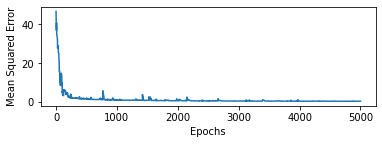

Testing
Testing Error is  0.4585511055731931


In [92]:
SGD4 = Regression(x_train_trans_4, x_test_trans_4, train_y, test_y)
SGD4.fit(x_train_trans_4, train_y,epochs = 5000, learning='SGD', learning_rate=0.001)

In [113]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD4.pickle', 'wb')
# pickle.dump(SGD4, file)
# file.close()

**MODIFIED MODEL**

In [115]:
class PolynomialRegression():

    def __init__(self, degree):
        self.w = None
        #self.X_train, self.X_test, self.y_train, self.y_test = X_train,X_test,y_train, y_test
        self.degree = degree

    def transform(self,X):
        '''
        Transforms the features to degre d polynomial features
        '''
        X_trans = np.ones((len(X[:,1]), 1), dtype=int)
        for i in range(self.degree+1):
            for j in range(self.degree+1-i):
                if i!=0 or j!=0:
                    t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
                    X_trans = np.concatenate((X_trans, t.T), axis=1)
        return X_trans

    def polynomial(self, X):    
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])  

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        return (y_pred - y)*x

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)[0]
        print("Testing Error is ", test_loss)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=True, printValues=True):

        self.w = np.random.randn(1, X.shape[1])     

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        count=0
        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)   
                    self.w -= learning_rate * (dw/X.shape[0])   

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)   
                self.w -= learning_rate * dw   

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]  
                if printValues and i%50==0:
                    print('Epoch:', i,'Loss:', loss[i])

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

        #self.evaluate(self.X_test,self.y_test)

**5 Degree Polynomial**

In [ ]:
#x_train_trans_5 = transform(train_X,5)
#x_test_trans_5 = transform(test_X,5)


Training...


  0%|          | 0/1600 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 178.32920055192253
Epoch: 50 Loss: 4.484403662387639
Epoch: 100 Loss: 0.79376563067338
Epoch: 150 Loss: 0.5052203753845566
Epoch: 200 Loss: 0.4227930345687382
Epoch: 250 Loss: 0.38650401787937416
Epoch: 300 Loss: 0.36566897285739663
Epoch: 350 Loss: 0.35108065955043466
Epoch: 400 Loss: 0.33954316682861296
Epoch: 450 Loss: 0.3298010626175652
Epoch: 500 Loss: 0.32128562099725155
Epoch: 550 Loss: 0.3136956036215143
Epoch: 600 Loss: 0.30684678188756653
Epoch: 650 Loss: 0.3006134070360163
Epoch: 700 Loss: 0.2949030479107186
Epoch: 750 Loss: 0.28964442365235027
Epoch: 800 Loss: 0.28478077443607125
Epoch: 850 Loss: 0.2802658592889168
Epoch: 900 Loss: 0.27606134530378906
Epoch: 950 Loss: 0.27213500840474714
Epoch: 1000 Loss: 0.2684594439087043
Epoch: 1050 Loss: 0.265011114896931
Epoch: 1100 Loss: 0.26176963324612784
Epoch: 1150 Loss: 0.2587172057019609
Epoch: 1200 Loss: 0.2558381999012801
Epoch: 1250 Loss: 0.25311879941876997
Epoch: 1300 Loss: 0.2505467261310103
Epoch: 1350 Loss

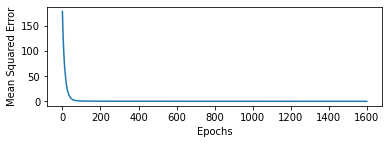

Testing
Testing Error is  0.24310860078286026


In [122]:
GD5 = PolynomialRegression(5)
x_train_trans_5 = GD5.transform(train_X)
x_test_trans_5 = GD5.transform(test_X)
GD5.fit(x_train_trans_5, train_y,epochs = 1600, learning='GD', learning_rate=0.00002)
GD5.evaluate(x_test_trans_5,test_y)

In [123]:
#  file = open('/content/gdrive/My Drive/FODSAssignment/GD5.pickle', 'wb')
#  pickle.dump(GD5, file)
#  file.close()

Training...


  0%|          | 0/6700 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 115.72104788341666
Epoch: 50 Loss: 44.38545811069039
Epoch: 100 Loss: 29.990864353576438
Epoch: 150 Loss: 17.449747971700642
Epoch: 200 Loss: 20.515988604124136
Epoch: 250 Loss: 23.226426881951742
Epoch: 300 Loss: 25.559187668402824
Epoch: 350 Loss: 19.69835319094302
Epoch: 400 Loss: 13.043078656935123
Epoch: 450 Loss: 13.866492912113467
Epoch: 500 Loss: 7.572432570798894
Epoch: 550 Loss: 13.717312709583084
Epoch: 600 Loss: 9.716241678827997
Epoch: 650 Loss: 11.63545617791523
Epoch: 700 Loss: 395.6686742165036
Epoch: 750 Loss: 103.22577208750074
Epoch: 800 Loss: 10.222712452344059
Epoch: 850 Loss: 4.43849269135157
Epoch: 900 Loss: 2.544674375333904
Epoch: 950 Loss: 4.062321846877831
Epoch: 1000 Loss: 5.441253044139432
Epoch: 1050 Loss: 2.0865638359095118
Epoch: 1100 Loss: 5.730812127630716
Epoch: 1150 Loss: 1.6323084423030019
Epoch: 1200 Loss: 2.1370707736097962
Epoch: 1250 Loss: 1.6903913288749273
Epoch: 1300 Loss: 2.138615320274761
Epoch: 1350 Loss: 3.0314973452685328


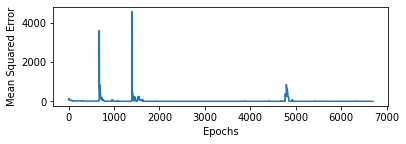

Testing
Testing Error is  0.3599693471272299


In [148]:
SGD5 = PolynomialRegression(5)
x_train_trans_5 = SGD5.transform(train_X)
x_test_trans_5 = SGD5.transform(test_X)
SGD5.fit(x_train_trans_5, train_y,epochs = 6700, learning='SGD', learning_rate=0.0005)
SGD5.evaluate(x_test_trans_5,test_y)

In [149]:
 file = open('/content/gdrive/My Drive/FODSAssignment/SGD5.pickle', 'wb')
 pickle.dump(SGD5, file)
 file.close()

**6 Degree Polynomial**

Training...


  0%|          | 0/2500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 348.3631663769241
Epoch: 50 Loss: 10.766551057557013
Epoch: 100 Loss: 2.160472342681156
Epoch: 150 Loss: 1.2537053024720946
Epoch: 200 Loss: 0.9401642887142072
Epoch: 250 Loss: 0.7595744217841007
Epoch: 300 Loss: 0.6414047246132792
Epoch: 350 Loss: 0.5592742614958647
Epoch: 400 Loss: 0.4998364894956587
Epoch: 450 Loss: 0.45551481293322255
Epoch: 500 Loss: 0.4216670600056526
Epoch: 550 Loss: 0.39528495285414195
Epoch: 600 Loss: 0.37433772786178754
Epoch: 650 Loss: 0.3574132353293408
Epoch: 700 Loss: 0.3435079599502579
Epoch: 750 Loss: 0.33189715033131334
Epoch: 800 Loss: 0.3220508425986437
Epoch: 850 Loss: 0.31357763625713403
Epoch: 900 Loss: 0.30618602880103507
Epoch: 950 Loss: 0.29965727760833066
Epoch: 1000 Loss: 0.2938260556053406
Epoch: 1050 Loss: 0.28856649942990453
Epoch: 1100 Loss: 0.2837820560475416
Epoch: 1150 Loss: 0.2793980422415274
Epoch: 1200 Loss: 0.2753561624728712
Epoch: 1250 Loss: 0.27161045221661684
Epoch: 1300 Loss: 0.2681242656076275
Epoch: 1350 Loss:

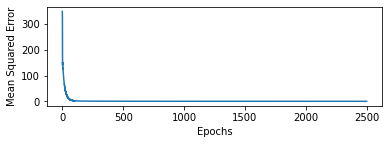

Testing
Testing Error is  0.23972206869894122


In [155]:
GD6 = PolynomialRegression(6)
x_train_trans_6 = GD6.transform(train_X)
x_test_trans_6 = GD6.transform(test_X)
GD6.fit(x_train_trans_6, train_y,epochs = 2500, learning='GD', learning_rate=0.00002)
GD6.evaluate(x_test_trans_6,test_y)

In [156]:
#  file = open('/content/gdrive/My Drive/FODSAssignment/GD6.pickle', 'wb')
#  pickle.dump(GD6, file)
#  file.close()

Training...


  0%|          | 0/10000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 507.7767145684795
Epoch: 50 Loss: 190.09217174521166
Epoch: 100 Loss: 5324.368426897578
Epoch: 150 Loss: 1081.8958143874677
Epoch: 200 Loss: 1224.273887521919
Epoch: 250 Loss: 493.76878735642384
Epoch: 300 Loss: 497.76731115543885
Epoch: 350 Loss: 233.71078013446154
Epoch: 400 Loss: 230.42737598053534
Epoch: 450 Loss: 98.91158536420454
Epoch: 500 Loss: 82.35245473359196
Epoch: 550 Loss: 49.96776019000027
Epoch: 600 Loss: 50.108447064416005
Epoch: 650 Loss: 80.21743964607755
Epoch: 700 Loss: 37.888710596636685
Epoch: 750 Loss: 35.18804813740855
Epoch: 800 Loss: 33.02633774321641
Epoch: 850 Loss: 29.043118068481547
Epoch: 900 Loss: 28.79043460459949
Epoch: 950 Loss: 30.517882622533353
Epoch: 1000 Loss: 22.660422920985702
Epoch: 1050 Loss: 32.25420881586401
Epoch: 1100 Loss: 14.834482909103073
Epoch: 1150 Loss: 81.78642193818297
Epoch: 1200 Loss: 14.905412528383163
Epoch: 1250 Loss: 16.69754093789754
Epoch: 1300 Loss: 12.906193483832212
Epoch: 1350 Loss: 20.493640210428076


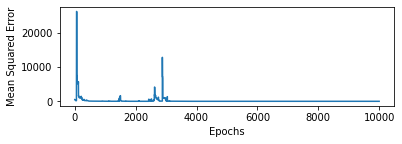

Testing
Testing Error is  2.385960818043685


In [169]:
#### NOT FINISHED ###
SGD6 = PolynomialRegression(6)
x_train_trans_6 = SGD6.transform(train_X)
x_test_trans_6 = SGD6.transform(test_X)
SGD6.fit(x_train_trans_6, train_y,epochs = 10000, learning='SGD', learning_rate=0.000076)
SGD6.evaluate(x_test_trans_6,test_y)

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD6.pickle', 'wb')
# pickle.dump(SGD6, file)
# file.close()

**7 Degree Polynomial**[[NOT COMPLETE]]

Training...


  0%|          | 0/6000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 5119.620088633711
Epoch: 50 Loss: 1693.7852710149998
Epoch: 100 Loss: 586.9976188052327
Epoch: 150 Loss: 206.1259818233095
Epoch: 200 Loss: 73.87910231466681
Epoch: 250 Loss: 27.619408136983125
Epoch: 300 Loss: 11.24871644562639
Epoch: 350 Loss: 5.3290207829084135
Epoch: 400 Loss: 3.099747017401745
Epoch: 450 Loss: 2.1970810957990397
Epoch: 500 Loss: 1.7869325618589205
Epoch: 550 Loss: 1.5700906884639056
Epoch: 600 Loss: 1.436028141692625
Epoch: 650 Loss: 1.3418459542608987
Epoch: 700 Loss: 1.2695739023935149
Epoch: 750 Loss: 1.2108703216388461
Epoch: 800 Loss: 1.161386667010696
Epoch: 850 Loss: 1.1185952703825415
Epoch: 900 Loss: 1.0808926385406796
Epoch: 950 Loss: 1.0471942066562996
Epoch: 1000 Loss: 1.0167316327852178
Epoch: 1050 Loss: 0.9889412562306443
Epoch: 1100 Loss: 0.9633978090980869
Epoch: 1150 Loss: 0.9397727381789932
Epoch: 1200 Loss: 0.9178069246182251
Epoch: 1250 Loss: 0.8972922828344667
Epoch: 1300 Loss: 0.8780590409575135
Epoch: 1350 Loss: 0.859966755439

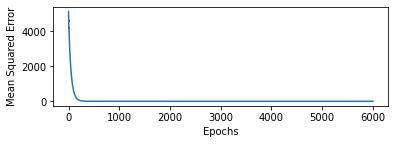

Testing
Testing Error is  0.45102126516162105


In [182]:
GD7 = PolynomialRegression(7)
x_train_trans_7 = GD7.transform(train_X)
x_test_trans_7 = GD7.transform(test_X)
GD7.fit(x_train_trans_7, train_y,epochs = 6000, learning='GD', learning_rate=0.00000085) #max possible learning rate , can be run for more epochs
GD7.evaluate(x_test_trans_7,test_y)

In [183]:
 file = open('/content/gdrive/My Drive/FODSAssignment/GD7.pickle', 'wb')
 pickle.dump(GD7, file)
 file.close()

In [ ]:
SGD7 = PolynomialRegression(7)
x_train_trans_7 = SGD7.transform(train_X)
x_test_trans_7 = SGD7.transform(test_X)
SGD7.fit(x_train_trans_7, train_y,epochs = 6000, learning='SGD', learning_rate=0.0005)
SGD7.evaluate(x_test_trans_7,test_y)

Training...


  0%|          | 0/6000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 306.04525386900514
Epoch: 50 Loss: 18.16905165772413
Epoch: 100 Loss: 13.340724042437744
Epoch: 150 Loss: 9.710956286160055
Epoch: 200 Loss: 7.348558991977139
Epoch: 250 Loss: 9.514948508748075
Epoch: 300 Loss: 7.062190035393865
Epoch: 350 Loss: 8.811126263258343
Epoch: 400 Loss: 189.18899377488307
Epoch: 450 Loss: 8.18210075258419
Epoch: 500 Loss: 4.58442269557848
Epoch: 550 Loss: 5.402646455981156
Epoch: 600 Loss: 6.8119829880082765
Epoch: 650 Loss: 3.6761922033991543
Epoch: 700 Loss: 4.6065645321470505
Epoch: 750 Loss: 3.678479771071779
Epoch: 800 Loss: 3.653060528849845
Epoch: 850 Loss: 2.8399398808245055
Epoch: 900 Loss: 4.43656576360943
Epoch: 950 Loss: 159.94875440478535
Epoch: 1000 Loss: 81.40201245757429
Epoch: 1050 Loss: 15.222640524902037
Epoch: 1100 Loss: 6.371384412364055
Epoch: 1150 Loss: 3.036529780188673
Epoch: 1200 Loss: 2.749180477156717
Epoch: 1250 Loss: 2.1649467603095687
Epoch: 1300 Loss: 1.773841051028265
Epoch: 1350 Loss: 1.8831065853918
Epoch: 140

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD7.pickle', 'wb')
# pickle.dump(SGD7, file)
# file.close()

**8 Degree Polynomial** [[NOT FINISHED]]

Training...


  0%|          | 0/1600 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 178.32920055192253
Epoch: 50 Loss: 4.484403662387639
Epoch: 100 Loss: 0.79376563067338
Epoch: 150 Loss: 0.5052203753845566
Epoch: 200 Loss: 0.4227930345687382
Epoch: 250 Loss: 0.38650401787937416
Epoch: 300 Loss: 0.36566897285739663
Epoch: 350 Loss: 0.35108065955043466
Epoch: 400 Loss: 0.33954316682861296
Epoch: 450 Loss: 0.3298010626175652
Epoch: 500 Loss: 0.32128562099725155
Epoch: 550 Loss: 0.3136956036215143
Epoch: 600 Loss: 0.30684678188756653
Epoch: 650 Loss: 0.3006134070360163
Epoch: 700 Loss: 0.2949030479107186
Epoch: 750 Loss: 0.28964442365235027
Epoch: 800 Loss: 0.28478077443607125
Epoch: 850 Loss: 0.2802658592889168
Epoch: 900 Loss: 0.27606134530378906
Epoch: 950 Loss: 0.27213500840474714
Epoch: 1000 Loss: 0.2684594439087043
Epoch: 1050 Loss: 0.265011114896931
Epoch: 1100 Loss: 0.26176963324612784
Epoch: 1150 Loss: 0.2587172057019609
Epoch: 1200 Loss: 0.2558381999012801
Epoch: 1250 Loss: 0.25311879941876997
Epoch: 1300 Loss: 0.2505467261310103
Epoch: 1350 Loss

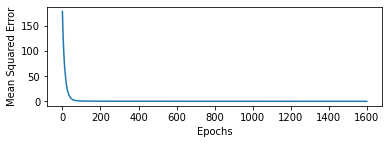

Testing
Testing Error is  0.24310860078286026


In [ ]:
GD8 = PolynomialRegression(8)
x_train_trans_8 = GD8.transform(train_X)
x_test_trans_8 = GD8.transform(test_X)
GD8.fit(x_train_trans_8, train_y,epochs = 1600, learning='GD', learning_rate=0.00002)
GD8.evaluate(x_test_trans_8,test_y)

In [ ]:
#  file = open('/content/gdrive/My Drive/FODSAssignment/GD8.pickle', 'wb')
#  pickle.dump(GD8, file)
#  file.close()

In [ ]:
SGD8 = PolynomialRegression(8)
x_train_trans_8 = SGD8.transform(train_X)
x_test_trans_8 = SGD8.transform(test_X)
SGD8.fit(x_train_trans_8, train_y,epochs = 6000, learning='SGD', learning_rate=0.0005)
SGD8.evaluate(x_test_trans_8,test_y)

Training...


  0%|          | 0/6000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 306.04525386900514
Epoch: 50 Loss: 18.16905165772413
Epoch: 100 Loss: 13.340724042437744
Epoch: 150 Loss: 9.710956286160055
Epoch: 200 Loss: 7.348558991977139
Epoch: 250 Loss: 9.514948508748075
Epoch: 300 Loss: 7.062190035393865
Epoch: 350 Loss: 8.811126263258343
Epoch: 400 Loss: 189.18899377488307
Epoch: 450 Loss: 8.18210075258419
Epoch: 500 Loss: 4.58442269557848
Epoch: 550 Loss: 5.402646455981156
Epoch: 600 Loss: 6.8119829880082765
Epoch: 650 Loss: 3.6761922033991543
Epoch: 700 Loss: 4.6065645321470505
Epoch: 750 Loss: 3.678479771071779
Epoch: 800 Loss: 3.653060528849845
Epoch: 850 Loss: 2.8399398808245055
Epoch: 900 Loss: 4.43656576360943
Epoch: 950 Loss: 159.94875440478535
Epoch: 1000 Loss: 81.40201245757429
Epoch: 1050 Loss: 15.222640524902037
Epoch: 1100 Loss: 6.371384412364055
Epoch: 1150 Loss: 3.036529780188673
Epoch: 1200 Loss: 2.749180477156717
Epoch: 1250 Loss: 2.1649467603095687
Epoch: 1300 Loss: 1.773841051028265
Epoch: 1350 Loss: 1.8831065853918
Epoch: 140

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD8.pickle', 'wb')
# pickle.dump(SGD8, file)
# file.close()